In [1]:
!pip install albumentations
!pip install transformers
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
/bin/sh: apt: command not found
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import math
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visuals and CV2
import cv2

# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold, train_test_split

#torch
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, lr_scheduler

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from sklearn.model_selection import GroupKFold
%cd '/home/ec2-user/SageMaker/dl-ecommerce-duplicates/'
from modules.datasets.TextArcFaceLossShopeeDataset import TextArcFaceLossShopeeDataset
from modules.models.BertWithArcFace import BertWithArcFace
from modules.utils.training_utils import train_fn
import faiss
import gc
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.CommonVIsualizer import CommonVisualizer
import os

/home/ec2-user/SageMaker/dl-ecommerce-duplicates


# Configuration

In [3]:
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 32
EPOCHS = 10
SEED = 2020
LR = 5e-5
thresholds = np.arange(0.7, 0.99, 0.01)
device = torch.device('cuda')

################################################# MODEL ####################################################################

transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
TOKENIZER = transformers.AutoTokenizer.from_pretrained(transformer_model)

################################################ Metric Loss and its params #######################################################
loss_module = 'arcface'#'softmax'
s = 30.0
m = 0.5 
ls_eps = 0.0
easy_margin = False

############################################################################################################################
model_params = {
    'n_classes':11014,
    'model_name':transformer_model,
    'pooling':'clf',
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    'loss_module':loss_module,
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'mode_train':True
}


# Some Helper Functions

In [4]:
def run(data):
    # Defining DataSet
    train_dataset = TextArcFaceLossShopeeDataset(tokenizer,data)
    #Batch train loder
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        pin_memory=True,
        drop_last=True,
        num_workers=NUM_WORKERS
    )

    # Defining Model for specific fold
    model = BertWithArcFace(**model_params).to(device)

    ## Common Setups
    #DEfining criterion
    criterion = nn.CrossEntropyLoss().to(device)

    # Defining Optimizer with weight decay to params other than bias and layer norms
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
            ]  

    optimizer = AdamW(optimizer_parameters, lr=LR)

    #Defining LR SCheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader)*2, 
        num_training_steps=len(train_loader)*EPOCHS
    )

    # Create an empty DataFrame with the desired column names
    loss_df = pd.DataFrame(columns=['Epoch', 'Train_Loss'])
    
    # THE ENGINE LOOP
    # best_loss = 10000
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_loader, model,criterion, optimizer, device,scheduler=scheduler,epoch=epoch)
        # Append a row to the DataFrame with the epoch number and loss
        loss_df = loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
        # torch.save(model.state_dict(),f'sentence_transfomer_xlm_best_loss_num_epochs_{EPOCHS}_{loss_module}.bin')
        
    return model, loss_df
        # if train_loss.avg < best_loss:
        #     best_loss = train_loss.avg
        #     torch.save(model.state_dict(),f'sentence_transfomer_xlm_best_loss_num_epochs_{EPOCHS}_{loss_module}.bin')

In [5]:
def get_text_embeddings(df,TEXT_MODEL_PATH):
    embeds = []
    
    model = BertWithArcFace(**model_params)
    model.eval()
    
    model.load_state_dict(dict(list(torch.load(TEXT_MODEL_PATH).items())[:-1]),strict=False)
    model = model.to(device)

    text_dataset = TextArcFaceLossShopeeDataset(tokenizer,df)
    text_loader = torch.utils.data.DataLoader(
        text_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        drop_last=False,
        num_workers=NUM_WORKERS
    )
    
    
    with torch.no_grad():
        for input_ids, attention_mask,_ in tqdm(text_loader): 
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            feat = model(input_ids, attention_mask,None)
            text_embeddings = feat.detach().cpu().numpy()
            embeds.append(text_embeddings)
    
    
    del model
    text_embeddings = np.concatenate(embeds)
    print(f'Our text embeddings shape is {text_embeddings.shape}')
    del embeds
    gc.collect()
    return text_embeddings

In [57]:
def get_text_embeddings(df,TEXT_MODEL_PATH):
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    embeds = []
    losses = []
    
    model = BertWithArcFace(**model_params)
    model.eval()
    
    model.load_state_dict(dict(list(torch.load(TEXT_MODEL_PATH).items())[:-1]),strict=False)
    model = model.to(device)

    text_dataset = TextArcFaceLossShopeeDataset(tokenizer,df)
    text_loader = torch.utils.data.DataLoader(
        text_dataset,
        batch_size=TEST_BATCH_SIZE,
        pin_memory=True,
        drop_last=False,
        num_workers=NUM_WORKERS
    )
    
    criterion = nn.CrossEntropyLoss().to(device)
    
    with torch.no_grad():
        for input_ids, attention_mask,labels in tqdm(text_loader): 
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()
            feat,outputs = model(input_ids, attention_mask,labels)
            text_embeddings = feat.detach().cpu().numpy()
            embeds.append(text_embeddings)
            
            # Compute the validation loss
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    
    loss_valid = np.mean(losses)
    
    del model
    text_embeddings = np.concatenate(embeds)
    print(f'Our text embeddings shape is {text_embeddings.shape}')
    del embeds
    gc.collect()
    return text_embeddings,loss_valid
    # return text_embeddings

In [58]:
def read_dataset():
    df_cu = pd.DataFrame()
    if GET_CV:
        df = pd.read_csv('../shopee-product-matching/train80.csv')
        tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
        df['target'] = df['label_group'].map(tmp)
        df['target'] = df['target'].apply(lambda x: ' '.join(x))
        grouped = df.groupby('label_group')['posting_id'].apply(list)
        df['target'] = df['label_group'].map(grouped)
    else:
        df = pd.read_csv('../shopee-product-matching/valid20.csv')
        tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
        df['target'] = df['label_group'].map(tmp)
        df['target'] = df['target'].apply(lambda x: ' '.join(x))
        grouped = df.groupby('label_group')['posting_id'].apply(list)
        df['target'] = df['label_group'].map(grouped)
        
    return df

# TRAIN

In [10]:
df = pd.read_csv('../shopee-product-matching/train80.csv')
encoder = LabelEncoder()
df['label_group'] = encoder.fit_transform(df['label_group'])

### XLM Roberta Baseline, No FC, 10 Epochs, No Loss

In [11]:
#XLM Roberta Baseline, No FC, 10 Epochs, No Loss
transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_model)


EPOCHS = 10
model_params['loss_module'] = 'noloss'
model_params['mode_train'] = True
model,loss_df = run(df)


model_name = 'xlm_no_loss_10_epochs'
train_loss_file = os.path.join('results/', model_name + '_train_loss.csv')
model_file = os.path.join('results/', model_name + '.bin')


torch.save(model.state_dict(), model_file)
loss_df.to_csv(train_loss_file)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 856/856 [05:51<00:00,  2.44it/s, Epoch=0, LR=2.5e-5, Train_Loss=9.23] 
/tmp/ipykernel_15864/2219122214.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_df = loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)


# INFERENCE

In [52]:
GET_CV = True
df = read_dataset()
encoder = LabelEncoder()
df['label_group'] = encoder.fit_transform(df['label_group'])
len(df)

27399

### XLM Roberta Baseline, No FC, 10 Epochs, No Loss

In [22]:
transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_model)

EPOCHS = 1
TEST_BATCH_SIZE = 32
model_params['loss_module'] = 'noloss'
model_params['mode_train'] = False
# model_params['n_classes'] = len(df)

model_name = 'xlm_no_loss_10_epochs'
test_loss_file = os.path.join('results/', model_name + '_test_loss.csv')
model_file = os.path.join('results/', model_name + '.bin')
text_embeddings,val = get_text_embeddings(df,model_name)

100%|██████████| 30/30 [03:54<00:00,  7.81s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


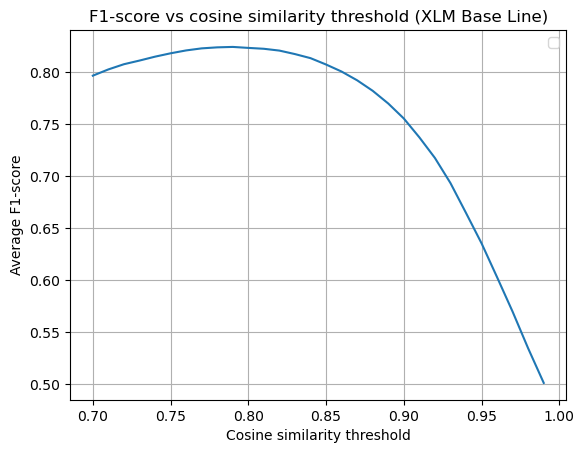

In [55]:
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = "XLM Base Line",filename = "xlm_final_nofc_softmax_10_epochs_chart")

In [48]:
# train_losses = [9.23,8.43,7.34,6.24,5.32,4.56,3.96,3.52,3.21,3.04]
# val_losses = [0]
# loss_name = "None - Just basleine"
# filename = "xlm_final_nofc_softmax_10_epochs_loss"
# CommonVisualizer().plt_losses( train_losses, val_losses, model_name, loss_name, filename)